# AIPI 590 - XAI | Assignment #06
## Mechanistic Interpretability
## Shaunak Badani

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/shaunak-badani/XAI/blob/main/Assignment05/ExplainableDeepLearning.ipynb)

> This notebook goes over a demo of the superposition hypothesis in the field of Mechanistic Interpretability

In [1]:
!pip install einops


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
from torch import nn
from torch.nn import functional as F

from typing import Optional

from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import trange

import time
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

In [4]:
n_features = 5
n_hidden = 2
n_instances = 10

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [6]:
W = nn.Parameter(torch.empty((n_instances, n_features, n_hidden), device=device))

In [14]:
print(W.max(), W.min())

tensor(8.4570e+37, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-4.2865e+37, device='cuda:0', grad_fn=<MinBackward1>)


- We initialize the weight matrix with a xavier normal distribution in the following cell:

In [22]:
_ = nn.init.xavier_normal_(W)
print(W.min(), W.max())

tensor(-0.5689, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4992, device='cuda:0', grad_fn=<MaxBackward1>)


In [23]:
b_final = nn.Parameter(torch.zeros((n_instances, n_features), device=device))

In [31]:
importance = (0.9**torch.arange(n_features))[np.newaxis, :]

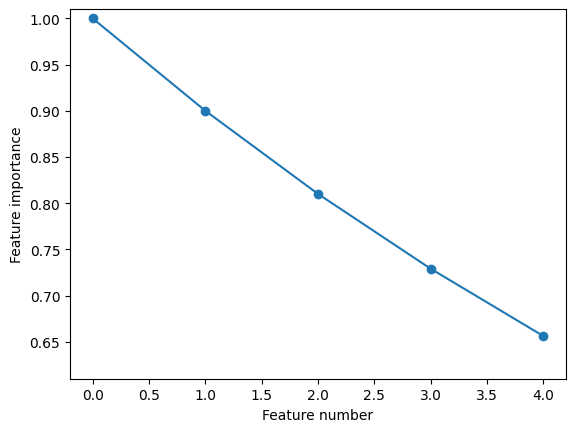

In [48]:
plt.plot(importance.squeeze())
plt.ylim([0.61, 1.01])
plt.xlabel('Feature number')
plt.ylabel('Feature importance')
plt.scatter(torch.arange(n_features), importance.squeeze())

In [70]:
feature_probability = (20 ** -torch.linspace(0, 1, n_instances, device = device))[:, None]

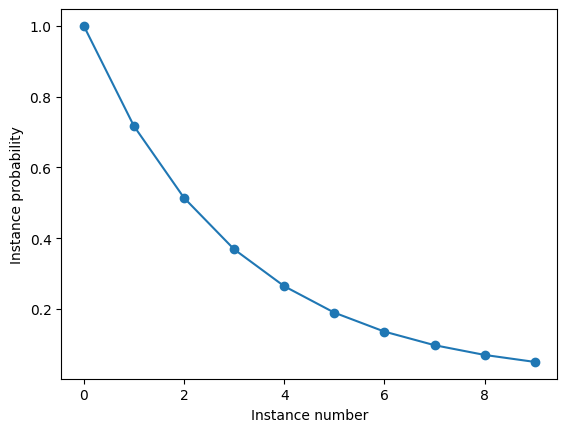

In [54]:
plt.plot(feature_probability.squeeze())
# plt.ylim([0.61, 1.01])
plt.xlabel('Instance number')
plt.ylabel('Instance probability')
plt.scatter(torch.arange(n_instances), feature_probability.squeeze())

In [65]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.W = W
        self.b = b_final
        self.feature_importance = importance
        self.feature_probability = feature_probability

    def forward(self, x):
        hidden = torch.einsum("...if,ifh->...ih", x, self.W)
        return hidden
model = Model()

In [74]:
def generate_batch(n_batch):
    feat = torch.rand((n_batch, n_instances, n_features), device=device)
    batch = torch.where(
        torch.rand((n_batch, n_instances, n_features), device=device) <= feature_probability,
        feat,
        torch.zeros((), device=device),
    )
    return batch
test_batch = generate_batch(1)
print(test_batch.shape)

torch.Size([1, 10, 5])


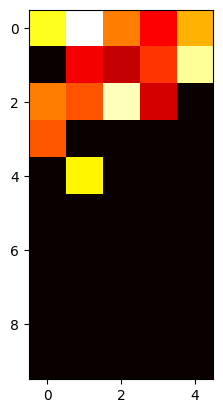

In [76]:
plt.imshow(test_batch.squeeze().cpu().detach(), cmap = 'hot')

In [63]:
optimizer = torch.optim.AdamW(list(model.parameters()), lr=1e-3)

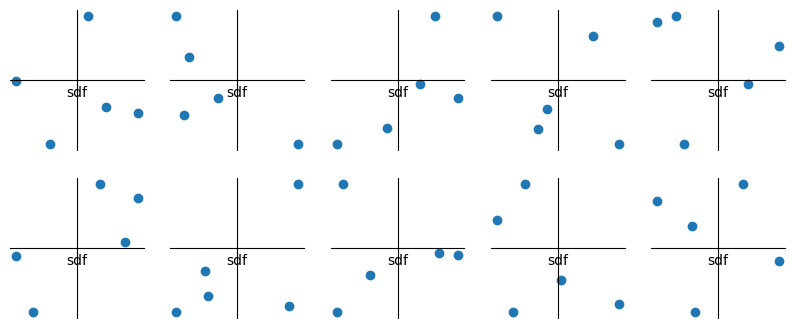

In [101]:
K, N, _ = W.shape
w = W.detach().cpu().numpy()

fig, axes = plt.subplots(2, K // 2, figsize = (K, 4), subplot_kw = {'xticks': [], 'yticks': [], 'xlabel': "sdf"})
for i, ax in enumerate(axes.flatten()):
    ax.scatter(w[i, :, 0], w[i, :, 1])
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom','left']:
        ax.spines[spine].set_position('center')

In [123]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.W = W
        self.b = b_final
        self.feature_importance = importance
        self.feature_probability = feature_probability

    def forward(self, x):
        hidden = torch.einsum("...if,ifh->...ih", x, self.W)
        # tmp_hidden = x @ hidden
        # new_vector = 
        # print(tmp_hidden)
        print(x.shape)
        print(self.W.shape)
        return hidden
model = Model()
test_batch = generate_batch(1)
model(test_batch).shape

torch.Size([1, 10, 5])
torch.Size([10, 5, 2])


torch.Size([1, 10, 2])

In [124]:
hidden = torch.einsum("...if,ifh->...ih", test_batch, model.W)

In [125]:
hidden

tensor([[[ 0.2460,  0.5662],
         [-0.0538,  0.0608],
         [ 0.3078, -0.2240],
         [-0.2736,  0.1068],
         [-0.0307,  0.0510],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]]], device='cuda:0', grad_fn=<ViewBackward0>)

In [126]:
C = torch.zeros(1, 10, 2)

for k in range(1):
    for i in range(10):
        for h in range(2):
            val = 0
            for f in range(5):
                val += test_batch[k, i, f] * model.W[i, f, h]
            C[k, i, h] = val
print(C)

tensor([[[ 0.2460,  0.5662],
         [-0.0538,  0.0608],
         [ 0.3078, -0.2240],
         [-0.2736,  0.1068],
         [-0.0307,  0.0510],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]]], grad_fn=<CopySlices>)


In [128]:
C = torch.zeros(1, 10, 2, device = device)

for k in range(1):
    for i in range(10):
        for h in range(2):
            C[k, i, h] += (test_batch[k, i, :] * model.W[i, :, h]).sum() 
print(C)

tensor([[[ 0.2460,  0.5662],
         [-0.0538,  0.0608],
         [ 0.3078, -0.2240],
         [-0.2736,  0.1068],
         [-0.0307,  0.0510],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]]], device='cuda:0', grad_fn=<CopySlices>)


In [129]:
C = torch.zeros(1, 10, 2, device = device)

for k in range(1):
    for i in range(10):
        C[k, i] = (test_batch[k, i, :] @ model.W[i, :, :])
print(C)

tensor([[[ 0.2460,  0.5662],
         [-0.0538,  0.0608],
         [ 0.3078, -0.2240],
         [-0.2736,  0.1068],
         [-0.0307,  0.0510],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]]], device='cuda:0', grad_fn=<CopySlices>)
